## F1 Validation with Rockefeller Dataset

I only manually labeled 15 .wav files per bird, so fewer than are in the UTSW colony validation, which is why these are secondary and just to show generalization. 

In [2]:
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import avn.dataloading as dataloading
import avn.segmentation as segmentation
import avn.plotting
import math
import sklearn
import seaborn as sns

In [3]:
def vak_to_syll_table(prediction_results):
  prediction_syllables = prediction_results[prediction_results['label'] == "s"]
  prediction_syll_reformat = pd.DataFrame()
  prediction_syll_reformat["files"] = prediction_syllables['audio_path']
  prediction_syll_reformat['onsets'] = prediction_syllables['onset_s']
  prediction_syll_reformat['offsets'] = prediction_syllables['offset_s']

  return prediction_syll_reformat

In [4]:
from scipy.io import wavfile
import librosa
import re
import scipy.signal
import pandas as pd
class SongFile:
    """
    Data and metadata pertaining to a single audio file.
    
    
    Attributes
    ----------
    data: ndarray
        Contains audio data of wavfile. 
    
    sample_rate: int
        Sample rate of song data. Based on native sample rate of wavfile.
    
    duration: float
        Duration of the audio file in seconds. 
    
    file_path: str
        Path to the local .wav file used to instantiate the SongFile object.
    
    Methods
    -------
    bandpass_filter(lower_cutoff, upper_cutoff)
        Applies a hamming window bandpass filter to the audio data. 
    
    """
    def __init__(self, file_path):
        """
        Parameters
        ----------
        file_path : str
            Path to the local .wav file to be loaded as a SongFile object.
             
        """
        self.sample_rate, self.data = wavfile.read(file_path)
        self.data = self.data.astype(float)
        self.duration = librosa.get_duration(y = self.data, sr = self.sample_rate)
        self.file_path = file_path
        
        #get file name -- This may be windows specific. 
        file_name_regex = re.compile("\\\\")
        self.file_name = file_name_regex.split(self.file_path)[-1]
                                                  
    def bandpass_filter(self, lower_cutoff, upper_cutoff):
        """
        Applies a hamming window bandpass filter to the audio data.

        Parameters
        ----------
        lower_cutoff : int
            Lower cutoff frequency in Hz for the filter. 
        upper_cutoff : int
            Upper cutoff frequency in Hz for the filter. 

        Returns
        -------
        None.

        """
        #create hamming window filter
        filter_bandpass = scipy.signal.firwin(101, cutoff = [lower_cutoff, upper_cutoff], 
                                              fs = self.sample_rate, 
                                              pass_zero = False)
        #apply filter to audio data
        self.data = scipy.signal.lfilter(filter_bandpass, [1.0], self.data)

In [5]:
dataloading.SongFile = SongFile

In [6]:
def make_spec(syll_wav, hop_length, win_length, n_fft, amin, ref_db, min_level_db):
    spectrogram = librosa.stft(syll_wav, hop_length = hop_length, win_length = win_length, n_fft = n_fft)
    spectrogram_db = librosa.amplitude_to_db(np.abs(spectrogram), amin = amin, ref = ref_db)
    
    #normalize
    S_norm = np.clip((spectrogram_db - min_level_db) / -min_level_db, 0, 1)
    
    return S_norm
def clean_syll_table(syll_table): 
  '''
  Reformats syll tables imported from evsonganaly so that they are compatible
  with python generated ones

  Inputs
  ----
  syll_table: Pandas Dataframe, imported from a csv containing evsonganaly 
  segmentation and labeling info

  Outputs
  ----
  syll_table: Pandas Dataframe, now with corrected file names and timestamps in seconds

  Notes
  -----
  This function specifically removes .not.mat file extensions from the file names
  so that they are simply .wav and can be compared to file names in the MFCC
  segmentation generated syllable tables. It also converts the timestamps of 
  onsets and offsets from miliseconds to seconds, again so that it is consistent
  with the MFCC resuls
  ''' 

  syll_table['onsets'] = syll_table['onsets'] / 1000
  syll_table['offsets'] = syll_table['offsets'] / 1000

  syll_table['files'] = syll_table['files'].str.split('.not', 1).str[0]

  return syll_table
def plot_confusion_matrix(all_matches):
  temp_df = pd.DataFrame({"hand_labels": all_matches.hand_label, 
                          "clusters": all_matches.hdbscan_labels})
  conf_mat = pd.crosstab(temp_df.hand_labels, temp_df.clusters)
  conf_mat = conf_mat.div(conf_mat.sum(axis = 1), axis = 0) * 100

  plt.figure(figsize = (8,6))
  sns.heatmap(conf_mat, annot = True, fmt='.0f')
def merge_hdbscan_hand_dfs(hdbscan_df, hand_df):
  
  all_matches = pd.DataFrame()

  for song_file in hdbscan_df.files.unique():
    hdbscan_file = hdbscan_df[hdbscan_df.files == song_file]
    hdbscan_file = hdbscan_file.reset_index(drop = True)
    hand_file = hand_df[hand_df.files == song_file]

    if hand_file.shape[0] != 0:
      hand_onsets = hand_file.onsets
      hdbscan_onsets = hdbscan_file.onsets
      best_matches = get_best_matches(hand_onsets, hdbscan_onsets, max_gap = 0.1)
      matches_file = pd.DataFrame({"files" : song_file,
                                 "best_match" : best_matches.astype(int), 
                                 "hand_onset" : hand_file.onsets, 
                                 "hand_offset" : hand_file.offsets, 
                                 "hand_label" : hand_file.labels})
      matches_file = matches_file.merge(right = hdbscan_file, 
                                        left_on = 'best_match', 
                                        how = 'outer', 
                                        right_index = True)
    all_matches = all_matches.append(matches_file)

  return all_matches

def get_best_matches(first_onsets, second_onsets, max_gap = 0.1):
  '''
  Finds the best unique matches between timestamps in two sets, calcuated in different
  ways on the same file. These can reflect syllable onset or offset timestamps, 
  although I refer to them only as onsets for simplicity. 

  Inputs
  ------
  first_onsets: Pandas Series, Contains the timestamps in seconds of syllable onsets
  calculated with a particular method. 

  second_onsets: Pandas Seris, Contains the timestamps in seconds of syllable onsets
  calculated with a different method. 

  max_gap: int > 0, optional, maximum allowable time difference  in seconds 
  between onsets where they will still be considered a match.

  Outputs
  -------
  best_matches: numpy array, 1D, For every syllable onset in `first_onsets` it 
  contains the index of the best unique match in `second_onsets`. If there is 
  no unique match within the allowable `max_gap`, the value of the match is 
  `NaN`. 
  '''
  first_grid, second_grid = np.meshgrid(first_onsets, second_onsets)
  delta_t_grid = abs(first_grid - second_grid)

  #set max gap threshold
  delta_t_grid = np.where(delta_t_grid > max_gap, np.inf, delta_t_grid)

  if delta_t_grid.shape[0] == 0:
    best_matches = np.array([])
    return best_matches ############################################################################test

  #find best matches
  best_matches = np.argmin(delta_t_grid, axis = 0).astype(float)

  #remove matches were delta t is > max_gap
  for i, match_index in enumerate(best_matches):
    if np.isinf(delta_t_grid[int(match_index), i]):
      best_matches[i] = np.NaN 

  best_matches_previous = best_matches.copy()   

  #Deal with duplicate values by setting the second best matches to their second best pairs
  best_matches, delta_t_grid = correct_duplicates(best_matches, delta_t_grid)

  #check if there were changes made by checking for duplicates. If so, repeat duplicate check.
  if not np.allclose(best_matches, best_matches_previous):
    best_matches, delta_t_grid = correct_duplicates(best_matches, delta_t_grid)

  #make sure duplicate corrections didn't result in out of order matches. 
  for i, curr_match in enumerate(best_matches):
     if i+1 < len(best_matches):
       if curr_match > best_matches[i+1]:
         best_matches[i+1] = np.nan

  return best_matches
def correct_duplicates(best_matches, delta_t_grid):
  '''
  Finds any duplicate matches in the set of best matches, removes duplicates
  by setting all but best match to their second best match. 

  Inputs
  -----
  best_matches: numpy array, 1D, contains indices of onsets in one set which best 
  match the onsets in another set. 

  delta_t_grid: numpy array, 2D, contains all the absolute value time differences
  between all possible pairs of onsets in two sets being compared.

  Outputs
  -----
  best_matches: numpy array, 1D. Same as input, but with duplicate matches corrected

  delta_t_grid: numpy array, 2D. Same as input, but with values at duplicated 
  positions adjusted to allow finding second best match. 


  '''
  for i, match_index in enumerate(best_matches):
    if np.isnan(match_index):
      continue
    #check if match index is duplicated
    if len(np.argwhere(best_matches == match_index)) > 1: 
      #create list of indices of duplicates
      duplicates = np.nonzero(best_matches == match_index)[0]
      #find which duplicate has the smallest delta t
      delta_ts = []
      for n in duplicates:
        delta_ts.append(delta_t_grid[int(best_matches[n]), n])

      #get all but the best matches of the duplicates
      bad_matches = np.delete(duplicates, np.argmin(delta_ts))

      #find second best matches for all but the best duplicate matches

      for bad_match in bad_matches:
        delta_t_grid[int(best_matches[bad_match]), bad_match] = np.inf
        best_matches[bad_match] = np.argmin(delta_t_grid[:, bad_match])
        if np.isinf(np.min(delta_t_grid[:, bad_match])):
          best_matches[bad_match] = np.NaN
  return (best_matches, delta_t_grid)
def remove_nas_from_merge(all_matches, fill_char = 'x', fill_int = 1000):
  
  all_matches.hand_label = all_matches.hand_label.fillna(fill_char)
  all_matches.hdbscan_labels = all_matches.hdbscan_labels.fillna(fill_int)

  return all_matches

## Get List of Birds

In [7]:
pairs_df = pd.read_csv("C:/Grad_School/Code_and_software/Py_code/Rockefeller_validation/rockefeller_group1_pairs_df.csv")
All_Birds = pairs_df.Pupil_ID
All_Birds

0      LIME18
1       BRN20
2      Lime19
3       Lime7
4       LIME3
5        DB17
6        DB21
7        DB24
8       GRY30
9       BRN28
10     Lime29
11       AQ33
12       AQ30
13     LIME30
14       AQ32
15       AQ31
16     Ag51HP
17       LP16
18       GR27
19       LP19
20      GRY49
21      GRY28
22      GRY34
23    GRY37HP
24     GRY112
Name: Pupil_ID, dtype: object

# Onsets

## Calc F1 Scores

In [ ]:
all_seg_metrics = pd.DataFrame()
for Bird_ID in All_Birds[:]:

    #load whisperseg segmentation and reformat so it's consistent with avn
    wseg_segmentations = pd.read_csv('E:\\Final_Bird_Dataset\\WhisperSeg_Segmentation\\' + Bird_ID + "_wseg.csv")
    wseg_segmentations = wseg_segmentations.drop(columns = ['Unnamed: 0', 'cluster'])
    wseg_segmentations = wseg_segmentations.rename(columns = {'onset' : 'onsets', 
                                                            'offset' : 'offsets', 
                                                            'file' : 'files'})
    wseg_segmentations['labels'] = 's'
    
    #create seg data object. This is necessary for the F1 calculation
    seg_data = segmentation.SegData(Bird_ID, wseg_segmentations)
    #load ground truth segmentation and add to seg_data object
    song_folder = 'D:/Rockefeller_Song_Dataset/Pupils_labeled_subsets/' + Bird_ID + "/"
    ground_truth_path = song_folder + Bird_ID + "_syll_table.csv"
    seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)
    seg_data.true_seg_table['labels'] = 's'

    #drop any files that aren't in the true seg table as they will cause errors
    to_drop = set(seg_data.seg_table.files.unique()) - set(seg_data.true_seg_table.files.unique())
    seg_data.seg_table = seg_data.seg_table[~seg_data.seg_table.files.isin(to_drop)]

    #calculate F1 score for whisperSeg
    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.05)
    curr_seg_metrics = seg_data.seg_metrics
    #add to df with all seg metrics
    curr_seg_metrics['Bird_ID'] = Bird_ID
    curr_seg_metrics['max_gap'] = 0.05
    curr_seg_metrics['method'] = 'whisper_seg'
    all_seg_metrics = pd.concat([all_seg_metrics, curr_seg_metrics])

    #calculate F1 score for whisperSeg
    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.01)
    curr_seg_metrics = seg_data.seg_metrics
    #add to df with all seg metrics
    curr_seg_metrics['Bird_ID'] = Bird_ID
    curr_seg_metrics['max_gap'] = 0.01
    curr_seg_metrics['method'] = 'whisper_seg'
    all_seg_metrics = pd.concat([all_seg_metrics, curr_seg_metrics])

    #load tweetynet segmentations
    tweety_segs = pd.read_csv("D:/Rockefeller_Song_Dataset/tweety_segmentations_pupils/" + Bird_ID + ".annot.csv")
    tweety_segs = vak_to_syll_table(tweety_segs)

    #create seg data object. This is necessary for the F1 calculation
    seg_data = segmentation.SegData(Bird_ID, tweety_segs)
    seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)
    seg_data.true_seg_table['labels'] = 's'
    
    #drop any files that aren't in the true seg table as they will cause errors
    to_drop = set(seg_data.seg_table.files.unique()) - set(seg_data.true_seg_table.files.unique())
    seg_data.seg_table = seg_data.seg_table[~seg_data.seg_table.files.isin(to_drop)]

    #calculate F1 score for Tweetynet
    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.05)
    curr_seg_metrics = seg_data.seg_metrics
    #add to df with all seg metrics
    curr_seg_metrics['Bird_ID'] = Bird_ID
    curr_seg_metrics['max_gap'] = 0.05
    curr_seg_metrics['method'] = 'Tweety_net'
    all_seg_metrics = pd.concat([all_seg_metrics, curr_seg_metrics])

    #calculate F1 score for whisperSeg
    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.01)
    curr_seg_metrics = seg_data.seg_metrics
    #add to df with all seg metrics
    curr_seg_metrics['Bird_ID'] = Bird_ID
    curr_seg_metrics['max_gap'] = 0.01
    curr_seg_metrics['method'] = 'Tweety_net'
    all_seg_metrics = pd.concat([all_seg_metrics, curr_seg_metrics])



In [ ]:
all_seg_metrics

,F1,precision,recall,Bird_ID,max_gap,method
0,0.998987,1.000000,0.997976,LIME18,0.05,whisper_seg
0,0.982776,0.983773,0.981781,LIME18,0.01,whisper_seg
0,0.946360,0.898182,1.000000,LIME18,0.05,Tweety_net
0,0.922488,0.876364,0.973737,LIME18,0.01,Tweety_net
0,0.873990,0.996317,0.778417,BRN20,0.05,whisper_seg
...,...,...,...,...,...,...
0,0.982827,0.976378,0.989362,GRY37HP,0.01,Tweety_net
0,0.752475,1.000000,0.603175,GRY112,0.05,whisper_seg
0,0.750000,0.996711,0.601190,GRY112,0.01,whisper_seg
0,0.916911,0.896750,0.938000,GRY112,0.05,Tweety_net


## Get RMSE segmentation metrics

In [ ]:
all_F1s = pd.DataFrame()

for i, Bird_ID in enumerate(All_Birds):
    print("Bird: " + str(i) + "/" + str(len(All_Birds)))
    
    song_folder = 'D:/Rockefeller_Song_Dataset/Pupils_labeled_subsets/' + Bird_ID + "/"
    ground_truth_path = song_folder + Bird_ID + "_syll_table.csv"
    
    #do MFCC Segmentation
    segmenter = segmentation.RMSEDerivative()
    seg_data = segmenter.make_segmentation_table(Bird_ID, song_folder,
                                                 upper_threshold = 0.006, 
                                                 lower_threshold = -0.1)
    
    #Add ground truth data
    seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)
    seg_data.true_seg_table['labels'] = 's'

    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.01)
    
    seg_metrics = seg_data.seg_metrics
    seg_metrics["Bird_ID"] = [Bird_ID]
    all_F1s = all_F1s.append(seg_metrics)


Bird: 0/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2784417981.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 1/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2784417981.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 2/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2784417981.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 3/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2784417981.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 4/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2784417981.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 5/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2784417981.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 6/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2784417981.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 7/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2784417981.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 8/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2784417981.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 9/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2784417981.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 10/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2784417981.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 11/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2784417981.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 12/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2784417981.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 13/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2784417981.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 14/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2784417981.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 15/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2784417981.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 16/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2784417981.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 17/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2784417981.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 18/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2784417981.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 19/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2784417981.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 20/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2784417981.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 21/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2784417981.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 22/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2784417981.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 23/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2784417981.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 24/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2784417981.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


In [ ]:
all_F1s['method'] = 'RMSE'
all_F1s['max_gap'] = 0.01

In [ ]:
all_seg_metrics = pd.concat([all_seg_metrics, all_F1s])

In [ ]:
all_seg_metrics

,F1,precision,recall,Bird_ID,max_gap,method
0,0.998987,1.000000,0.997976,LIME18,0.05,whisper_seg
0,0.982776,0.983773,0.981781,LIME18,0.01,whisper_seg
0,0.946360,0.898182,1.000000,LIME18,0.05,Tweety_net
0,0.922488,0.876364,0.973737,LIME18,0.01,Tweety_net
0,0.873990,0.996317,0.778417,BRN20,0.05,whisper_seg
...,...,...,...,...,...,...
0,0.340058,0.316354,0.367601,GRY49,0.01,RMSE
0,0.451142,0.425862,0.479612,GRY28,0.01,RMSE
0,0.603145,0.539735,0.683438,GRY34,0.01,RMSE
0,0.381188,0.354023,0.412869,GRY37HP,0.01,RMSE


In [ ]:
all_seg_metrics.to_csv('C:\\Grad_School\\Code_and_software\\Py_code\\WhisperSeg_validation\\wseg_RMSE_tweety_F1s_rock.csv')

## Plot F1 Scores

In [8]:
all_seg_metrics = pd.read_csv('C:\\Grad_School\\Code_and_software\\Py_code\\WhisperSeg_validation\\wseg_RMSE_tweety_F1s_rock.csv')

In [9]:
import seaborn as sns

In [10]:
all_seg_metrics = all_seg_metrics[all_seg_metrics.max_gap == 0.01]

In [11]:
all_seg_metrics.method = pd.Categorical(all_seg_metrics.method).reorder_categories(['RMSE', 'Tweety_net', 'whisper_seg'])
all_seg_metrics.method = all_seg_metrics.method.cat.rename_categories({'Tweety_net' : "TweetyNet", 
                                                                       'whisper_seg' : "WhisperSeg"})

In [12]:
plt.rcParams.update({'font.size': 10})

In [13]:
all_seg_metrics.groupby('method').mean(numeric_only=True)

,Unnamed: 0,F1,precision,recall,max_gap
method,,,,,
RMSE,0.0,0.455187,0.409994,0.515115,0.01
TweetyNet,0.0,0.867529,0.856606,0.884896,0.01
WhisperSeg,0.0,0.890083,0.953024,0.843822,0.01


In [14]:
from scipy.stats import sem
print(sem(all_seg_metrics[all_seg_metrics.method == 'WhisperSeg'].F1))
print(sem(all_seg_metrics[all_seg_metrics.method == 'TweetyNet'].F1))
print(sem(all_seg_metrics[all_seg_metrics.method == 'RMSE'].F1))

0.017205213052734182
0.01772541662318636
0.027434055813546028


Text(0.5, 13.722222222222216, 'Method')

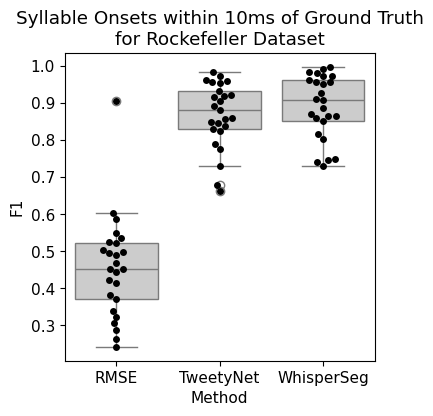

In [29]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'F1', color = 'black', s = 5)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'F1', color = '0.8')
plt.title("Syllable Onsets within 10ms of Ground Truth\nfor Rockefeller Dataset")
plt.xlabel('Method')

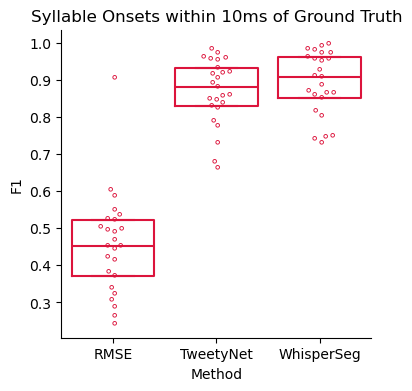

In [19]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'F1', color = 'crimson', s = 5, dodge = True, legend = False, 
              marker = "$\circ$")
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'F1', fill = False, color = 'crimson', fliersize=0, whis= 0, 
legend = False)
plt.title("Syllable Onsets within 10ms of Ground Truth")
plt.xlabel('Method')
sns.despine()
plt.savefig('rock_onset_f1s.svg')

Text(0, 0.5, 'Precision')

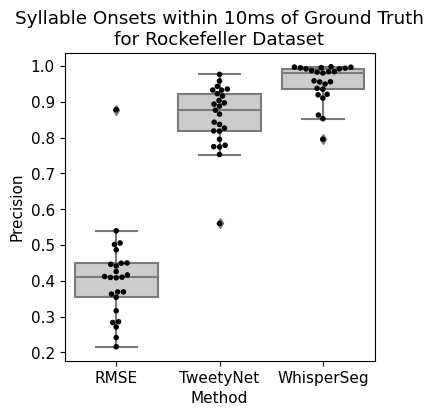

In [ ]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'precision', color = 'black', s = 4)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'precision', color = '0.8')
plt.title("Syllable Onsets within 10ms of Ground Truth\nfor Rockefeller Dataset")
plt.xlabel('Method')
plt.ylabel('Precision')

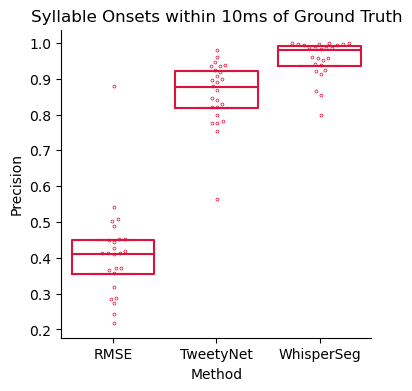

In [25]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'precision', color = 'crimson', s = 4, dodge = True, legend = False, 
              marker = "$\circ$", )
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'precision', fill = False, color = 'crimson', fliersize=0, whis= 0, 
legend = False)
plt.title("Syllable Onsets within 10ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Precision')
sns.despine()
plt.savefig('rock_onset_precision.svg')

Text(0, 0.5, 'Recall')

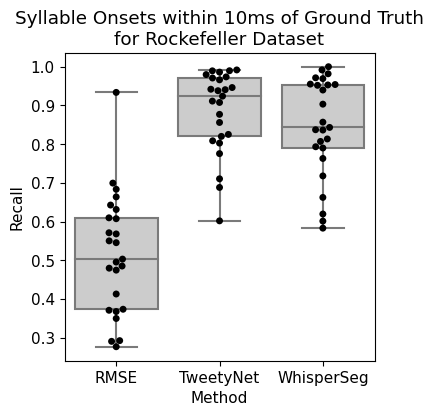

In [ ]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'recall', color = 'black', s = 5)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'recall', color = '0.8')
plt.title("Syllable Onsets within 10ms of Ground Truth\nfor Rockefeller Dataset")
plt.xlabel('Method')
plt.ylabel('Recall')

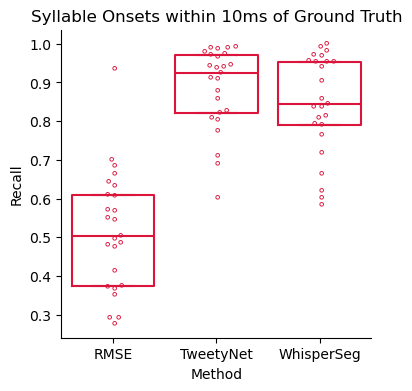

In [27]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'recall', color = 'crimson', s = 5, dodge = True, legend = False, 
               marker = "$\circ$",)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'recall', fill = False, color = 'crimson', fliersize=0, whis= 0, 
legend = False)
plt.title("Syllable Onsets within 10ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Recall')
sns.despine()

plt.savefig('rock_onset_recall.svg')


# Offsets

## Calc F1 Scores

In [ ]:
all_seg_metrics = pd.DataFrame()
for Bird_ID in All_Birds[:]:

    #load whisperseg segmentation and reformat so it's consistent with avn
    wseg_segmentations = pd.read_csv('E:\\Final_Bird_Dataset\\WhisperSeg_Segmentation\\' + Bird_ID + "_wseg.csv")
    wseg_segmentations = wseg_segmentations.drop(columns = ['Unnamed: 0', 'cluster'])
    wseg_segmentations = wseg_segmentations.rename(columns = {'onset' : 'onsets', 
                                                            'offset' : 'offsets', 
                                                            'file' : 'files'})
    wseg_segmentations['labels'] = 's'
    
    #create seg data object. This is necessary for the F1 calculation
    seg_data = segmentation.SegData(Bird_ID, wseg_segmentations)
    #load ground truth segmentation and add to seg_data object
    song_folder = 'D:/Rockefeller_Song_Dataset/Pupils_labeled_subsets/' + Bird_ID + "/"
    ground_truth_path = song_folder + Bird_ID + "_syll_table.csv"
    seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)
    seg_data.true_seg_table['labels'] = 's'

    #drop any files that aren't in the true seg table as they will cause errors
    to_drop = set(seg_data.seg_table.files.unique()) - set(seg_data.true_seg_table.files.unique())
    seg_data.seg_table = seg_data.seg_table[~seg_data.seg_table.files.isin(to_drop)]

    #calculate F1 score for whisperSeg
    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.05, feature = 'offsets')
    curr_seg_metrics = seg_data.seg_metrics
    #add to df with all seg metrics
    curr_seg_metrics['Bird_ID'] = Bird_ID
    curr_seg_metrics['max_gap'] = 0.05
    curr_seg_metrics['method'] = 'whisper_seg'
    all_seg_metrics = pd.concat([all_seg_metrics, curr_seg_metrics])

    #calculate F1 score for whisperSeg
    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.02, feature = 'offsets')
    curr_seg_metrics = seg_data.seg_metrics
    #add to df with all seg metrics
    curr_seg_metrics['Bird_ID'] = Bird_ID
    curr_seg_metrics['max_gap'] = 0.02
    curr_seg_metrics['method'] = 'whisper_seg'
    all_seg_metrics = pd.concat([all_seg_metrics, curr_seg_metrics])

    #load tweetynet segmentations
    tweety_segs = pd.read_csv("D:/Rockefeller_Song_Dataset/tweety_segmentations_pupils/" + Bird_ID + ".annot.csv")
    tweety_segs = vak_to_syll_table(tweety_segs)

    #create seg data object. This is necessary for the F1 calculation
    seg_data = segmentation.SegData(Bird_ID, tweety_segs)
    seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)
    seg_data.true_seg_table['labels'] = 's'
    
    #drop any files that aren't in the true seg table as they will cause errors
    to_drop = set(seg_data.seg_table.files.unique()) - set(seg_data.true_seg_table.files.unique())
    seg_data.seg_table = seg_data.seg_table[~seg_data.seg_table.files.isin(to_drop)]

    #calculate F1 score for Tweetynet
    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.05, feature = 'offsets')
    curr_seg_metrics = seg_data.seg_metrics
    #add to df with all seg metrics
    curr_seg_metrics['Bird_ID'] = Bird_ID
    curr_seg_metrics['max_gap'] = 0.05
    curr_seg_metrics['method'] = 'Tweety_net'
    all_seg_metrics = pd.concat([all_seg_metrics, curr_seg_metrics])

    #calculate F1 score for whisperSeg
    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.02, feature = 'offsets')
    curr_seg_metrics = seg_data.seg_metrics
    #add to df with all seg metrics
    curr_seg_metrics['Bird_ID'] = Bird_ID
    curr_seg_metrics['max_gap'] = 0.02
    curr_seg_metrics['method'] = 'Tweety_net'
    all_seg_metrics = pd.concat([all_seg_metrics, curr_seg_metrics])





c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In 

In [ ]:
all_seg_metrics

,F1,precision,recall,Bird_ID,max_gap,method
0,0.996960,0.997972,0.995951,LIME18,0.05,whisper_seg
0,0.977778,0.981744,0.973843,LIME18,0.02,whisper_seg
0,0.946360,0.898182,1.000000,LIME18,0.05,Tweety_net
0,0.940613,0.892727,0.993927,LIME18,0.02,Tweety_net
0,0.870759,0.992634,0.775540,BRN20,0.05,whisper_seg
...,...,...,...,...,...,...
0,0.988111,0.981627,0.994681,GRY37HP,0.02,Tweety_net
0,0.750000,0.996711,0.601190,GRY112,0.05,whisper_seg
0,0.742574,0.986842,0.595238,GRY112,0.02,whisper_seg
0,0.916911,0.896750,0.938000,GRY112,0.05,Tweety_net


## Get RMSE segmentation metrics

In [ ]:
all_F1s = pd.DataFrame()

for i, Bird_ID in enumerate(All_Birds):
    print("Bird: " + str(i) + "/" + str(len(All_Birds)))
    
    song_folder = 'D:/Rockefeller_Song_Dataset/Pupils_labeled_subsets/' + Bird_ID + "/"
    ground_truth_path = song_folder + Bird_ID + "_syll_table.csv"
    
    #do MFCC Segmentation
    segmenter = segmentation.RMSEDerivative()
    seg_data = segmenter.make_segmentation_table(Bird_ID, song_folder,
                                                 upper_threshold = 0.006, 
                                                 lower_threshold = -0.1)
    
    #Add ground truth data
    seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)
    seg_data.true_seg_table['labels'] = 's'

    seg_data = segmentation.Metrics.calc_F1(seg_data, max_gap = 0.02, feature= 'offsets')
    
    seg_metrics = seg_data.seg_metrics
    seg_metrics["Bird_ID"] = [Bird_ID]
    all_F1s = all_F1s.append(seg_metrics)


Bird: 0/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2032323634.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 1/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2032323634.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 2/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2032323634.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 3/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2032323634.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 4/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2032323634.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 5/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2032323634.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 6/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2032323634.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 7/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2032323634.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 8/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2032323634.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 9/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2032323634.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 10/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2032323634.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 11/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2032323634.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 12/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2032323634.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 13/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2032323634.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 14/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2032323634.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 15/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2032323634.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 16/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2032323634.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 17/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2032323634.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 18/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2032323634.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 19/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2032323634.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 20/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2032323634.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 21/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2032323634.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 22/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2032323634.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 23/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2032323634.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


Bird: 24/25


c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\2032323634.py:23: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_F1s = all_F1s.append(seg_metrics)


In [ ]:
all_F1s['method'] = 'RMSE'
all_F1s['max_gap'] = 0.02

In [ ]:
all_seg_metrics = pd.concat([all_seg_metrics, all_F1s])

In [ ]:
all_seg_metrics

,F1,precision,recall,Bird_ID,max_gap,method
0,0.996960,0.997972,0.995951,LIME18,0.05,whisper_seg
0,0.977778,0.981744,0.973843,LIME18,0.02,whisper_seg
0,0.946360,0.898182,1.000000,LIME18,0.05,Tweety_net
0,0.940613,0.892727,0.993927,LIME18,0.02,Tweety_net
0,0.870759,0.992634,0.775540,BRN20,0.05,whisper_seg
...,...,...,...,...,...,...
0,0.011445,0.010724,0.012270,GRY49,0.02,RMSE
0,0.030994,0.029310,0.032882,GRY28,0.02,RMSE
0,0.053211,0.048013,0.059671,GRY34,0.02,RMSE
0,0.054254,0.050575,0.058511,GRY37HP,0.02,RMSE


In [ ]:
all_seg_metrics.to_csv('C:\\Grad_School\\Code_and_software\\Py_code\\WhisperSeg_validation\\wseg_RMSE_tweety_F1s_offsets_rock.csv')

## Plot F1 Scores

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot  as plt

In [2]:
all_seg_metrics = pd.read_csv('C:\\Grad_School\\Code_and_software\\Py_code\\WhisperSeg_validation\\wseg_RMSE_tweety_F1s_offsets_rock.csv')

In [3]:
all_seg_metrics = all_seg_metrics[all_seg_metrics.max_gap == 0.02]

In [4]:
all_seg_metrics.method = pd.Categorical(all_seg_metrics.method).reorder_categories(['RMSE', 'Tweety_net', 'whisper_seg'])
all_seg_metrics.method = all_seg_metrics.method.cat.rename_categories({'Tweety_net' : "TweetyNet", 
                                                                       'whisper_seg' : "WhisperSeg"})

In [5]:
plt.rcParams.update({'font.size': 10})

In [6]:
all_seg_metrics.groupby('method').mean(numeric_only=True)

,Unnamed: 0,F1,precision,recall,max_gap
method,,,,,
RMSE,0.0,0.049453,0.044540,0.055908,0.02
TweetyNet,0.0,0.921398,0.909720,0.940378,0.02
WhisperSeg,0.0,0.901499,0.963998,0.855584,0.02


In [7]:
from scipy.stats import sem
print(sem(all_seg_metrics[all_seg_metrics.method == 'WhisperSeg'].F1))
print(sem(all_seg_metrics[all_seg_metrics.method == 'TweetyNet'].F1))
print(sem(all_seg_metrics[all_seg_metrics.method == 'RMSE'].F1))

0.017888442025176723
0.010747647170923356
0.008625804849928953


Text(0.5, 0, 'Method')

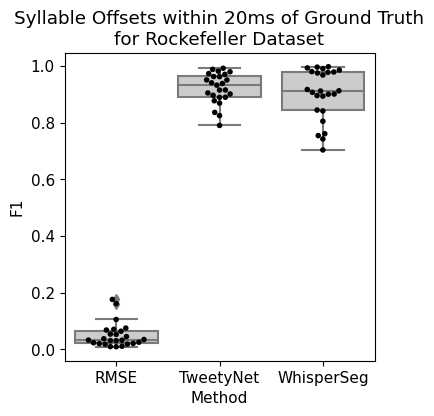

In [ ]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'F1', color = 'black', s = 4)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'F1', color = '0.8')
plt.title("Syllable Offsets within 20ms of Ground Truth\nfor Rockefeller Dataset")
plt.xlabel('Method')

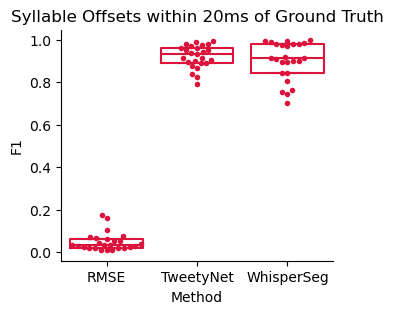

In [8]:
plt.figure(figsize = (3.5, 3))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'F1', color = 'crimson', s = 4, dodge = True, legend = False)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'F1', fill = False, color = 'crimson', fliersize=0, whis= 0, 
legend = False)
plt.title("Syllable Offsets within 20ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('F1')
sns.despine()
plt.savefig('rock_offsets_f1.svg')

Text(0, 0.5, 'Precision')

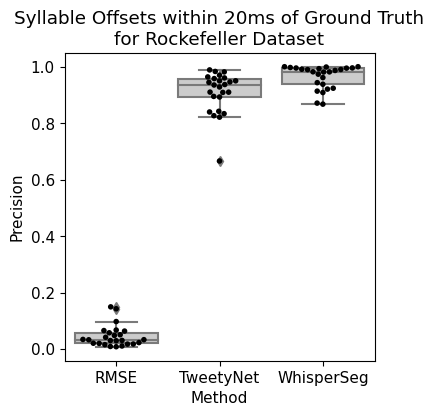

In [ ]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'precision', color = 'black', s = 4)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'precision', color = '0.8')
plt.title("Syllable Offsets within 20ms of Ground Truth\nfor Rockefeller Dataset")
plt.xlabel('Method')
plt.ylabel('Precision')

c:\Users\tkoch\anaconda3\envs\avn4_install_test\lib\site-packages\seaborn\categorical.py:3399: UserWarning: 12.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


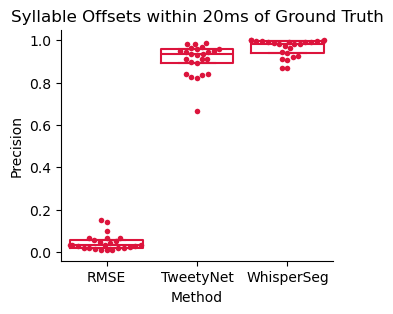

In [9]:
plt.figure(figsize = (3.5, 3))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'precision', color = 'crimson', s = 4, dodge = True, legend = False)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'precision', fill = False, color = 'crimson', fliersize=0, whis= 0, 
legend = False)
plt.title("Syllable Offsets within 20ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Precision')
sns.despine()
plt.savefig('rock_offsets_precision.svg')

Text(0, 0.5, 'Recall')

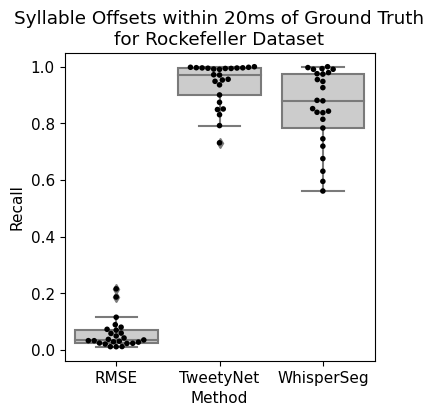

In [ ]:
plt.figure(figsize = (4, 4))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'recall', color = 'black', s = 4)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'recall', color = '0.8')
plt.title("Syllable Offsets within 20ms of Ground Truth\nfor Rockefeller Dataset")
plt.xlabel('Method')
plt.ylabel('Recall')

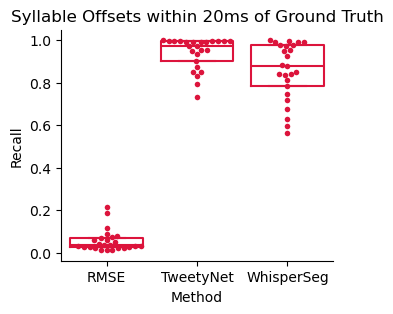

In [10]:
plt.figure(figsize = (3.5, 3))
sns.swarmplot(data = all_seg_metrics, x = 'method', y = 'recall', color = 'crimson', s = 4, dodge = True, legend = False)
sns.boxplot(data = all_seg_metrics, x = 'method', y = 'recall', fill = False, color = 'crimson', fliersize=0, whis= 0, 
legend = False)
plt.title("Syllable Offsets within 20ms of Ground Truth")
plt.xlabel('Method')
plt.ylabel('Recall')
sns.despine()
plt.savefig('rock_offsets_recall.svg')

# Onsets - Time Deltas

In [8]:
def get_match_times(truth_matches, seg_current_file):

    #initialize empty 1D array to contain timestamps
    matched_times = np.zeros_like(truth_matches)

    #loop through each match and add timestamp to matched_times
    for i, match_idx in enumerate(truth_matches):
        #if the match_idx is nan, that means the true syll had no match, so record nan as timestamp
        if np.isnan(match_idx):
            matched_times[i] = np.nan
        else: 
            matched_times[i] = seg_current_file.onsets.iloc[int(match_idx)]

    return matched_times

In [9]:
def get_time_delta_df(seg_data, max_gap = 0.05, feature = 'onsets'):
    #initialize dataframe to contain matched timestamps for all files
    all_matched_times = pd.DataFrame()

    #loop over each individual file
    for current_file in np.unique(seg_data.seg_table['files']):
        #Make copy of ground truth segmentation table
        truth_seg_table = seg_data.true_seg_table

        #filter the seg_tables so that they contain only syllables from the 
        #current file. 
        seg_current_file = seg_data.seg_table[seg_data.seg_table['files'] == current_file]
        truth_current_file = truth_seg_table[truth_seg_table['files'] == current_file]

        #get best matches of segmenter to truth onsets/offsets
        truth_matches = segmentation.Metrics._Metrics__get_best_matches(truth_current_file[feature], 
                                            seg_current_file[feature], max_gap)

        #create dataframe with matches and timestamps
        true_seg_matches_df = pd.DataFrame({'True_feat_times' : truth_current_file[feature], 
                                            'index_of_match' : truth_matches})

        #get timestamps of segmenter matches to truth
        matched_times = get_match_times(truth_matches, seg_current_file)

        #add matched timestamps to df of matches
        true_seg_matches_df['seg_matched_times'] = matched_times

        #add file name to df
        true_seg_matches_df['file'] = current_file

        #append df for current file to df with all files
        all_matched_times = pd.concat([all_matched_times, true_seg_matches_df])

    return all_matched_times

In [10]:
def get_time_deltas_many_birds(segmenter, Bird_IDs, folder_path, upper_threshold, lower_threshold, truth_table_suffix = "_syll_table.csv", 
                               max_gap = 0.05, feature = 'onsets'):

    #initialize empty dataframe to append to
    all_time_deltas_df = pd.DataFrame()

    #loop through each bird
    for Bird_ID in Bird_IDs: 
        #construct full path to folder containing song files
        song_folder = folder_path + Bird_ID + "/"

        #make segmentations
        seg_data = segmenter.make_segmentation_table(Bird_ID, song_folder,
                                                     upper_threshold = upper_threshold, 
                                                     lower_threshold = lower_threshold)

        #load ground truth segmentations from memory
        seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, song_folder + Bird_ID + truth_table_suffix)

        #get time delta table for current bird
        curr_time_delta_df = get_time_delta_df(seg_data, max_gap = max_gap, feature = feature)
        #add Bird_ID to current df
        curr_time_delta_df['Bird_ID'] = Bird_ID
        #append to df with all birds
        all_time_deltas_df = pd.concat([all_time_deltas_df, curr_time_delta_df])

    #add column with time deltas
    all_time_deltas_df['time_delta'] = all_time_deltas_df.True_feat_times - all_time_deltas_df.seg_matched_times

    return all_time_deltas_df

## Get Time Deltas 

In [11]:
pairs_df = pd.read_csv("C:/Grad_School/Code_and_software/Py_code/Rockefeller_validation/rockefeller_group1_pairs_df.csv")
All_Birds = pairs_df.Pupil_ID
All_Birds

0      LIME18
1       BRN20
2      Lime19
3       Lime7
4       LIME3
5        DB17
6        DB21
7        DB24
8       GRY30
9       BRN28
10     Lime29
11       AQ33
12       AQ30
13     LIME30
14       AQ32
15       AQ31
16     Ag51HP
17       LP16
18       GR27
19       LP19
20      GRY49
21      GRY28
22      GRY34
23    GRY37HP
24     GRY112
Name: Pupil_ID, dtype: object

### RMSE

In [12]:
song_folder = song_folder = 'E:/Rockefeller_Song_Dataset/Pupils_labeled_subsets/'
segmenter = segmentation.RMSEDerivative()

In [13]:
all_time_deltas_RMSE = get_time_deltas_many_birds(segmenter, All_Birds, song_folder, 
                                                upper_threshold = 0.006, lower_threshold= -0.1, max_gap = 0.01)

c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In 

### TweetyNet

In [14]:
def vak_to_syll_table(prediction_results):
  prediction_syllables = prediction_results[prediction_results['label'] == "s"]
  prediction_syll_reformat = pd.DataFrame()
  prediction_syll_reformat["files"] = prediction_syllables['audio_path']
  prediction_syll_reformat['onsets'] = prediction_syllables['onset_s']
  prediction_syll_reformat['offsets'] = prediction_syllables['offset_s']

  return prediction_syll_reformat

In [16]:
#initialize df with all birds' time deltas. 
all_time_deltas_Tweety = pd.DataFrame()

for Bird_ID in All_Birds: 

    #load tweetynet segmentation table
    predictions_path =  "E:/Rockefeller_Song_Dataset/tweety_segmentations_pupils/" + Bird_ID + ".annot.csv"
    predictions_vak = pd.read_csv(predictions_path)
    predictions_reformat = vak_to_syll_table(predictions_vak)

    #load ground truth
    song_folder = 'E:/Rockefeller_Song_Dataset/Pupils_labeled_subsets/' + Bird_ID + "/"
    ground_truth_path = song_folder + Bird_ID + "_syll_table.csv"

    #make SegData Object
    seg_data = segmentation.SegData(Bird_ID, predictions_reformat)
    seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)

    #calculate time deltas
    curr_bird_time_delta = get_time_delta_df(seg_data, max_gap = 0.01, feature = 'onsets')
    #append to df with all birds
    curr_bird_time_delta['Bird_ID'] = Bird_ID
    all_time_deltas_Tweety = pd.concat([all_time_deltas_Tweety, curr_bird_time_delta])

#add time delta column 
all_time_deltas_Tweety['time_delta'] = all_time_deltas_Tweety.True_feat_times - all_time_deltas_Tweety.seg_matched_times

c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In 

### Wseg

In [17]:
def get_time_delta_df(seg_data, max_gap = 0.01, feature = 'onsets'):
    #initialize dataframe to contain matched timestamps for all files
    all_matched_times = pd.DataFrame()

    #loop over each individual file
    for current_file in np.unique(seg_data.seg_table['files']):
        #Make copy of ground truth segmentation table
        truth_seg_table = seg_data.true_seg_table

        #filter the seg_tables so that they contain only syllables from the 
        #current file. 
        seg_current_file = seg_data.seg_table[seg_data.seg_table['files'] == current_file]
        truth_current_file = truth_seg_table[truth_seg_table['files'] == current_file]

        #get best matches of segmenter to truth onsets/offsets
        truth_matches = segmentation.Metrics._Metrics__get_best_matches(truth_current_file[feature], 
                                            seg_current_file[feature], max_gap)

        #create dataframe with matches and timestamps
        true_seg_matches_df = pd.DataFrame({'True_feat_times' : truth_current_file[feature], 
                                            'index_of_match' : truth_matches})

        #get timestamps of segmenter matches to truth
        matched_times = get_match_times(truth_matches, seg_current_file)

        #add matched timestamps to df of matches
        true_seg_matches_df['seg_matched_times'] = matched_times

        #add file name to df
        true_seg_matches_df['file'] = current_file

        #append df for current file to df with all files
        all_matched_times = pd.concat([all_matched_times, true_seg_matches_df])

    return all_matched_times

In [19]:
#initialize df with all birds' time deltas. 
all_time_deltas_wseg = pd.DataFrame()

for Bird_ID in All_Birds[:]: 

    #load tweetynet segmentation table
    predictions_path =  'D:\\Final_Bird_Dataset\\WhisperSeg_Segmentation\\' + Bird_ID + '_wseg.csv'
    predictions = pd.read_csv(predictions_path)
    predictions = predictions.drop(columns = ['Unnamed: 0', 'cluster'])
    predictions = predictions.rename(columns = {'onset' : 'onsets', 
                                                            'offset' : 'offsets', 
                                                            'file' : 'files'})

    #load ground truth
    song_folder = 'E:/Rockefeller_Song_Dataset/Pupils_labeled_subsets/' + Bird_ID + "/"
    ground_truth_path = song_folder + Bird_ID + "_syll_table.csv"

    #make SegData Object
    seg_data = segmentation.SegData(Bird_ID, predictions)
    seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)

    #calculate time deltas
    curr_bird_time_delta = get_time_delta_df(seg_data, max_gap = 0.01, feature = 'onsets')

    #append to df with all birds
    curr_bird_time_delta['Bird_ID'] = Bird_ID
    all_time_deltas_wseg = pd.concat([all_time_deltas_wseg, curr_bird_time_delta])

#add time delta column 
all_time_deltas_wseg['time_delta'] = all_time_deltas_wseg.True_feat_times - all_time_deltas_wseg.seg_matched_times

c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In 

## Merge Time Deltas

In [20]:
all_time_deltas_Tweety['Segmentation Method'] = "TweetyNet"
all_time_deltas_RMSE['Segmentation Method'] = "Amplitude Threshold" 
all_time_deltas_wseg['Segmentation Method'] = "WhisperSeg"

In [21]:
all_time_deltas = pd.concat([all_time_deltas_wseg, all_time_deltas_Tweety, all_time_deltas_RMSE,])

In [22]:
all_time_deltas.to_csv('rock_onset_time_deltas')

## Plot Time Deltas

In [28]:
import avn.segmentation as segmentation
import pandas as pd
import numpy as np
import avn.dataloading as dataloading
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
all_time_deltas = pd.read_csv('rock_onset_time_deltas')

In [31]:
plt.rcParams.update({'font.size': 10})

In [32]:
all_time_deltas['time_delta'] = all_time_deltas.time_delta * 1000

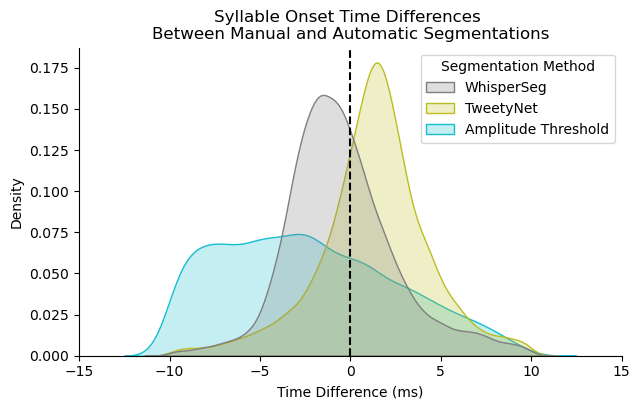

In [33]:
plt.figure(figsize = (7, 4))
sns.kdeplot(data = all_time_deltas.reset_index(), x = 'time_delta', hue = 'Segmentation Method', common_norm = False, fill = True, 
            palette= sns.color_palette()[-3:], legend = True)
plt.axvline(x = 0, color = 'black', linestyle = '--')
plt.xlim(-15, 15)
plt.xlabel("Time Difference (ms)")
plt.title("Syllable Onset Time Differences \nBetween Manual and Automatic Segmentations");
sns.despine()

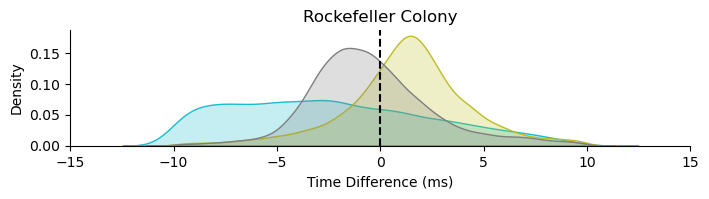

In [50]:
plt.figure(figsize = (8, 1.5))
ax = sns.kdeplot(data = all_time_deltas.reset_index(), x = 'time_delta', hue = 'Segmentation Method', common_norm = False, fill = True, 
            palette= sns.color_palette()[-3:], legend = False)
plt.axvline(x = 0, color = 'black', linestyle = '--')
plt.xlim(-15, 15)
plt.xlabel("Time Difference (ms)")
plt.title("Rockefeller Colony");
#sns.move_legend(ax, loc = 'upper left', bbox_to_anchor = (0.64, 1))
sns.despine()
plt.savefig('rock_onset_time_delta.svg', transparent = True)

In [54]:
all_time_deltas['abs_delta'] = np.abs(all_time_deltas.time_delta)

In [71]:
all_time_deltas.groupby('Segmentation Method').mean()

C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\3226881426.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_time_deltas.groupby('Segmentation Method').mean()


,True_feat_times,index_of_match,seg_matched_times,time_delta,abs_delta
Segmentation Method,,,,,
Amplitude Threshold,6.024826,24.704183,5.881290,-2.341423,4.522439
TweetyNet,6.024826,22.489417,6.024121,1.254613,2.576293
WhisperSeg,6.024826,19.017201,5.956534,-0.475807,2.369789


In [72]:
from scipy.stats import sem
print(sem(all_time_deltas[all_time_deltas['Segmentation Method'] == 'WhisperSeg'].abs_delta, nan_policy= 'omit'))
print(sem(all_time_deltas[all_time_deltas['Segmentation Method'] == 'TweetyNet'].abs_delta, nan_policy= 'omit'))
print(sem(all_time_deltas[all_time_deltas['Segmentation Method'] == 'Amplitude Threshold'].abs_delta, nan_policy= 'omit'))

0.01885852617668956
0.019937500083995665
0.03537114799432746


# Offset Time Deltas

In [6]:
def get_match_times(truth_matches, seg_current_file):

    #initialize empty 1D array to contain timestamps
    matched_times = np.zeros_like(truth_matches)

    #loop through each match and add timestamp to matched_times
    for i, match_idx in enumerate(truth_matches):
        #if the match_idx is nan, that means the true syll had no match, so record nan as timestamp
        if np.isnan(match_idx):
            matched_times[i] = np.nan
        else: 
            matched_times[i] = seg_current_file.offsets.iloc[int(match_idx)]

    return matched_times

In [7]:
def get_time_delta_df(seg_data, max_gap = 0.05, feature = 'onsets'):
    #initialize dataframe to contain matched timestamps for all files
    all_matched_times = pd.DataFrame()

    #loop over each individual file
    for current_file in np.unique(seg_data.seg_table['files']):
        #Make copy of ground truth segmentation table
        truth_seg_table = seg_data.true_seg_table

        #filter the seg_tables so that they contain only syllables from the 
        #current file. 
        seg_current_file = seg_data.seg_table[seg_data.seg_table['files'] == current_file]
        truth_current_file = truth_seg_table[truth_seg_table['files'] == current_file]

        #get best matches of segmenter to truth onsets/offsets
        truth_matches = segmentation.Metrics._Metrics__get_best_matches(truth_current_file[feature], 
                                            seg_current_file[feature], max_gap)

        #create dataframe with matches and timestamps
        true_seg_matches_df = pd.DataFrame({'True_feat_times' : truth_current_file[feature], 
                                            'index_of_match' : truth_matches})

        #get timestamps of segmenter matches to truth
        matched_times = get_match_times(truth_matches, seg_current_file)

        #add matched timestamps to df of matches
        true_seg_matches_df['seg_matched_times'] = matched_times

        #add file name to df
        true_seg_matches_df['file'] = current_file

        #append df for current file to df with all files
        all_matched_times = pd.concat([all_matched_times, true_seg_matches_df])

    return all_matched_times

In [8]:
def get_time_deltas_many_birds(segmenter, Bird_IDs, folder_path, upper_threshold, lower_threshold, truth_table_suffix = "_syll_table.csv", 
                               max_gap = 0.05, feature = 'onsets'):

    #initialize empty dataframe to append to
    all_time_deltas_df = pd.DataFrame()

    #loop through each bird
    for Bird_ID in Bird_IDs: 
        #construct full path to folder containing song files
        song_folder = folder_path + Bird_ID + "/"

        #make segmentations
        seg_data = segmenter.make_segmentation_table(Bird_ID, song_folder,
                                                     upper_threshold = upper_threshold, 
                                                     lower_threshold = lower_threshold)

        #load ground truth segmentations from memory
        seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, song_folder + Bird_ID + truth_table_suffix)

        #get time delta table for current bird
        curr_time_delta_df = get_time_delta_df(seg_data, max_gap = max_gap, feature = feature)
        #add Bird_ID to current df
        curr_time_delta_df['Bird_ID'] = Bird_ID
        #append to df with all birds
        all_time_deltas_df = pd.concat([all_time_deltas_df, curr_time_delta_df])

    #add column with time deltas
    all_time_deltas_df['time_delta'] = all_time_deltas_df.True_feat_times - all_time_deltas_df.seg_matched_times

    return all_time_deltas_df

## Get Time Deltas 

In [9]:
pairs_df = pd.read_csv("C:/Grad_School/Code_and_software/Py_code/Rockefeller_validation/rockefeller_group1_pairs_df.csv")
All_Birds = pairs_df.Pupil_ID
All_Birds

0      LIME18
1       BRN20
2      Lime19
3       Lime7
4       LIME3
5        DB17
6        DB21
7        DB24
8       GRY30
9       BRN28
10     Lime29
11       AQ33
12       AQ30
13     LIME30
14       AQ32
15       AQ31
16     Ag51HP
17       LP16
18       GR27
19       LP19
20      GRY49
21      GRY28
22      GRY34
23    GRY37HP
24     GRY112
Name: Pupil_ID, dtype: object

### RMSE

In [12]:
song_folder = song_folder = 'E:/Rockefeller_Song_Dataset/Pupils_labeled_subsets/'
segmenter = segmentation.RMSEDerivative()

In [13]:
all_time_deltas_RMSE = get_time_deltas_many_birds(segmenter, All_Birds, song_folder, 
                                                upper_threshold = 0.006, lower_threshold= -0.1, max_gap = 0.05, feature = 'offsets')

c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In 

### TweetyNet

In [14]:
def vak_to_syll_table(prediction_results):
  prediction_syllables = prediction_results[prediction_results['label'] == "s"]
  prediction_syll_reformat = pd.DataFrame()
  prediction_syll_reformat["files"] = prediction_syllables['audio_path']
  prediction_syll_reformat['onsets'] = prediction_syllables['onset_s']
  prediction_syll_reformat['offsets'] = prediction_syllables['offset_s']

  return prediction_syll_reformat

In [16]:
#initialize df with all birds' time deltas. 
all_time_deltas_Tweety = pd.DataFrame()

for Bird_ID in All_Birds: 

    #load tweetynet segmentation table
    predictions_path =  "E:/Rockefeller_Song_Dataset/tweety_segmentations_pupils/" + Bird_ID + ".annot.csv"
    predictions_vak = pd.read_csv(predictions_path)
    predictions_reformat = vak_to_syll_table(predictions_vak)

    #load ground truth
    song_folder = 'E:/Rockefeller_Song_Dataset/Pupils_labeled_subsets/' + Bird_ID + "/"
    ground_truth_path = song_folder + Bird_ID + "_syll_table.csv"

    #make SegData Object
    seg_data = segmentation.SegData(Bird_ID, predictions_reformat)
    seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)

    #calculate time deltas
    curr_bird_time_delta = get_time_delta_df(seg_data, max_gap = 0.05, feature = 'offsets')
    #append to df with all birds
    curr_bird_time_delta['Bird_ID'] = Bird_ID
    all_time_deltas_Tweety = pd.concat([all_time_deltas_Tweety, curr_bird_time_delta])

#add time delta column 
all_time_deltas_Tweety['time_delta'] = all_time_deltas_Tweety.True_feat_times - all_time_deltas_Tweety.seg_matched_times

c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In 

### Wseg

In [17]:
def get_time_delta_df(seg_data, max_gap = 0.01, feature = 'onsets'):
    #initialize dataframe to contain matched timestamps for all files
    all_matched_times = pd.DataFrame()

    #loop over each individual file
    for current_file in np.unique(seg_data.seg_table['files']):
        #Make copy of ground truth segmentation table
        truth_seg_table = seg_data.true_seg_table

        #filter the seg_tables so that they contain only syllables from the 
        #current file. 
        seg_current_file = seg_data.seg_table[seg_data.seg_table['files'] == current_file]
        truth_current_file = truth_seg_table[truth_seg_table['files'] == current_file]

        #get best matches of segmenter to truth onsets/offsets
        truth_matches = segmentation.Metrics._Metrics__get_best_matches(truth_current_file[feature], 
                                            seg_current_file[feature], max_gap)

        #create dataframe with matches and timestamps
        true_seg_matches_df = pd.DataFrame({'True_feat_times' : truth_current_file[feature], 
                                            'index_of_match' : truth_matches})

        #get timestamps of segmenter matches to truth
        matched_times = get_match_times(truth_matches, seg_current_file)

        #add matched timestamps to df of matches
        true_seg_matches_df['seg_matched_times'] = matched_times

        #add file name to df
        true_seg_matches_df['file'] = current_file

        #append df for current file to df with all files
        all_matched_times = pd.concat([all_matched_times, true_seg_matches_df])

    return all_matched_times

In [18]:
#initialize df with all birds' time deltas. 
all_time_deltas_wseg = pd.DataFrame()

for Bird_ID in All_Birds[:]: 

    #load tweetynet segmentation table
    predictions_path =  'D:\\Final_Bird_Dataset\\WhisperSeg_Segmentation\\' + Bird_ID + '_wseg.csv'
    predictions = pd.read_csv(predictions_path)
    predictions = predictions.drop(columns = ['Unnamed: 0', 'cluster'])
    predictions = predictions.rename(columns = {'onset' : 'onsets', 
                                                            'offset' : 'offsets', 
                                                            'file' : 'files'})

    #load ground truth
    song_folder = 'E:/Rockefeller_Song_Dataset/Pupils_labeled_subsets/' + Bird_ID + "/"
    ground_truth_path = song_folder + Bird_ID + "_syll_table.csv"

    #make SegData Object
    seg_data = segmentation.SegData(Bird_ID, predictions)
    seg_data = dataloading.Utils.add_ev_song_truth_table(seg_data, ground_truth_path)

    #calculate time deltas
    curr_bird_time_delta = get_time_delta_df(seg_data, max_gap = 0.05, feature = 'offsets')

    #append to df with all birds
    curr_bird_time_delta['Bird_ID'] = Bird_ID
    all_time_deltas_wseg = pd.concat([all_time_deltas_wseg, curr_bird_time_delta])

#add time delta column 
all_time_deltas_wseg['time_delta'] = all_time_deltas_wseg.True_feat_times - all_time_deltas_wseg.seg_matched_times

c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  true_seg_table['files'] = true_seg_table['files'].str.split('.not', 1).str[0]
c:\Users\tkoch\anaconda3\envs\avn_021_py38\lib\site-packages\avn\dataloading.py:151: FutureWarning: In 

## Merge Time Deltas

In [19]:
all_time_deltas_Tweety['Segmentation Method'] = "TweetyNet"
all_time_deltas_RMSE['Segmentation Method'] = "Amplitude Threshold" 
all_time_deltas_wseg['Segmentation Method'] = "WhisperSeg"

In [20]:
all_time_deltas = pd.concat([all_time_deltas_wseg, all_time_deltas_Tweety, all_time_deltas_RMSE,])

In [21]:
all_time_deltas.to_csv('rock_offset_time_deltas.csv')

## Plot Time Deltas

In [11]:
import avn.segmentation as segmentation
import pandas as pd
import numpy as np
import avn.dataloading as dataloading
import matplotlib.pyplot as plt
import seaborn as sns

In [12]:
all_time_deltas = pd.read_csv('rock_offset_time_deltas.csv')

In [13]:
plt.rcParams.update({'font.size': 10})

In [14]:
all_time_deltas['time_delta'] = all_time_deltas.time_delta * 1000

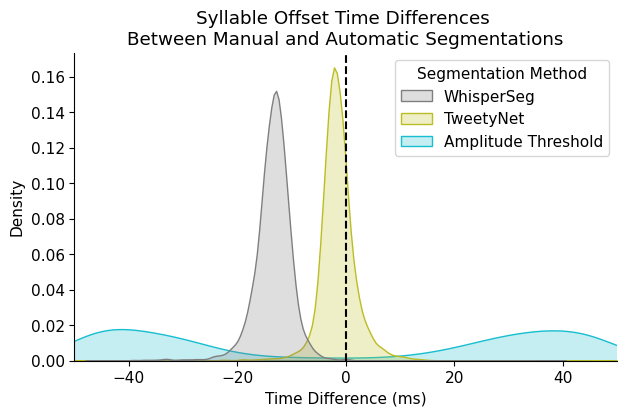

In [7]:
plt.figure(figsize = (7, 4))
sns.kdeplot(data = all_time_deltas.reset_index(), x = 'time_delta', hue = 'Segmentation Method', common_norm = False, fill = True, 
            palette= sns.color_palette()[-3:], legend = True)
plt.axvline(x = 0, color = 'black', linestyle = '--')
plt.xlim(-50, 50)
plt.xlabel("Time Difference (ms)")
plt.title("Syllable Offset Time Differences \nBetween Manual and Automatic Segmentations");
sns.despine()

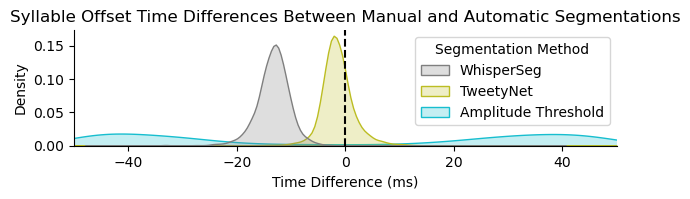

In [17]:
plt.figure(figsize = (7, 1.5))
sns.kdeplot(data = all_time_deltas.reset_index(), x = 'time_delta', hue = 'Segmentation Method', common_norm = False, fill = True, 
            palette= sns.color_palette()[-3:], legend = True)
plt.axvline(x = 0, color = 'black', linestyle = '--')
plt.xlim(-50, 50)
plt.xlabel("Time Difference (ms)")
plt.title("Syllable Offset Time Differences Between Manual and Automatic Segmentations");
sns.despine()
plt.savefig('rock_offset_time_deltas.svg')

In [120]:
all_time_deltas['abs_delta'] = np.abs(all_time_deltas.time_delta)

In [121]:
all_time_deltas.groupby('Segmentation Method').mean()

C:\Users\tkoch\AppData\Local\Temp\ipykernel_2576\3226881426.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  all_time_deltas.groupby('Segmentation Method').mean()


,True_feat_times,index_of_match,seg_matched_times,time_delta,abs_delta
Segmentation Method,,,,,
Amplitude Threshold,6.119528,27.672091,6.177682,-0.459787,35.313972
TweetyNet,6.119528,22.484950,6.089693,-1.583874,2.929811
WhisperSeg,6.119528,18.878657,6.073331,-13.433233,13.461012


In [122]:
from scipy.stats import sem
print(sem(all_time_deltas[all_time_deltas['Segmentation Method'] == 'WhisperSeg'].abs_delta, nan_policy= 'omit'))
print(sem(all_time_deltas[all_time_deltas['Segmentation Method'] == 'TweetyNet'].abs_delta, nan_policy= 'omit'))
print(sem(all_time_deltas[all_time_deltas['Segmentation Method'] == 'Amplitude Threshold'].abs_delta, nan_policy= 'omit'))

0.034875769863102306
0.031168138343924234
0.11878026642525435
